<a href="https://colab.research.google.com/github/18520381/434_Project_10/blob/main/VGG16%20Project/Copy_of_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get data

In [9]:
from google.colab import drive
from torchvision import models
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/data


In [10]:
import warnings
warnings.filterwarnings('ignore')

import cv2       
import os

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical    
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau

import random as rn
from tqdm import tqdm

Import data

In [ ]:
CLASS_NAME = ["apple", "orange"]
DATA_PATH = "../data/train/"
img_size = 112

images = []
labels = []
pbar = tqdm(total=2000)
for class_name in CLASS_NAME:
    for _, _, files in os.walk(DATA_PATH+class_name, topdown=False):
        for name in files:
            image = cv2.imread(DATA_PATH+""+class_name+"/"+name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_size,img_size))

            images.append(np.array(image))
            labels.append(str(class_name))

            pbar.update(1)
pbar.close()

100%|██████████| 2000/2000 [11:00<00:00,  3.03it/s]


In [ ]:
data = np.array(images)
labels = np.array(labels)

le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, 2)
X = data / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

np.random.seed(50)
rn.seed(50)

Setup a VGG16 

In [ ]:
size = img_size
fil = 8

model = Sequential()
model.add(Conv2D(input_shape=(size,size,3),filters=fil,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=fil,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*2, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*2, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalMaxPooling2D())
model.add(Dense(fil*2,activation='relu'))
model.add(Dense(2,activation="relu"))

In [ ]:
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

In [ ]:
datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 0,        
                              zca_whitening=False,
                              zoom_range=0.1,           
                              width_shift_range=0.1,   
                              height_shift_range=0.1,    
                              horizontal_flip=True,     
                              vertical_flip=False)       
                             
datagen.fit(X_train)

Compile and train the model

In [ ]:
model.save("/content/drive/MyDrive/ColabNotebooks/data/model4.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        4

In [ ]:
import tensorflow as tf
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ColabNotebooks/data/model4.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
model.compile(optimizer=Adam(lr = 1e-4), loss= 'categorical_crossentropy', metrics=['accuracy'])

batch_size=32

History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 1, validation_data = (X_test,y_test),                            
                              verbose = 1, steps_per_epoch= 25, callbacks=[model_checkpoint_callback])

Show accuracy and loss

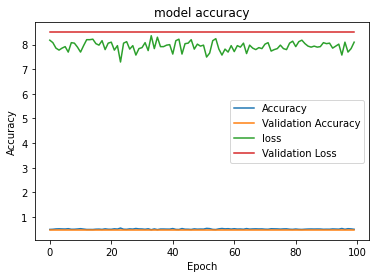

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history["accuracy"])
plt.plot(History.history['val_accuracy'])
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Save model


In [ ]:
model.save("/content/drive/MyDrive/ColabNotebooks/data/model4.h5")

1.   model2.h -> 4 layer first, 32 layer last
2.   model3.h -> 8 layer first, 32 layer last, softmax
3.   model4.h -> 8 layer first, 32 layer last, relu
4.   model6.h -> 8 layer first, 64 layer last




In [ ]:
base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5') 

loss, acc = base_model.evaluate(X_test, y_test, verbose=0)
print(f"Train accuracy {acc*100}")

Train accuracy 86.00000143051147


Testing

In [ ]:
import numpy as np
from keras.preprocessing import image
from tensorflow import keras
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

img_size = 112
saved_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5')

num = 200
accu = 0

for i in range(0, num):
  path = '/content/drive/MyDrive/ColabNotebooks/data/test/apple/apple_' + str(10000+i) + '.jpg'

  x = cv2.imread(path)
  x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

  x = x /255.0
  x = np.asarray(x) 
  x = np.expand_dims(x, axis=0)

  output = saved_model.predict(x)
  output = output.squeeze()
  if output[0] > output[1]:
    accu += 1

print("Test apple accuracy:" , accu/num*100)
accu = 0

for i in range(0, num):
  path = '/content/drive/MyDrive/ColabNotebooks/data/test/orange/orange_' + str(1000+i) + '.jpg'

  x = cv2.imread(path)
  x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

  x = x /255.0
  x = np.asarray(x) 
  x = np.expand_dims(x, axis=0)

  output = saved_model.predict(x)
  output = output.squeeze()
  if output[0] < output[1]:
    accu += 1

print("Test orange accuracy:" , accu/num*100)


Test apple accuracy: 99.0
Test orange accuracy: 99.5


1->13

In [ ]:
from tensorflow import keras
import cv2
import sys
import numpy
import re
import struct

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5')

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

size = 112
layer = 8

withd = [0,size,size,size//2,size//2,size//4,size//4,size//4,
         size//8,size//8,size//8,size//16,size//16,size//16]

conv = [0,3,layer,layer,layer*2,layer*2,layer*4,layer*4,layer*4,
        layer*4,layer*4,layer*4,layer*4,layer*4]
lay = [0,layer,layer,layer*2,layer*2,layer*4,layer*4,layer*4,layer*4,
       layer*4,layer*4,layer*4,layer*4,layer*4]

mod = [0,0,1,3,4,6,7,8,10,11,12,14,15,16]
pi_bi = [0,1,3,3,4,4,5,5,5,5,5,5,5,5]
pi_lay = [0,1,2,2,4,4,6,6,6,6,6,6,6,6]
con_lay = [0,1,2,3,4,5,6,7,6,6,7,6,6,13]
max = [False,False,True,False,True,False,False,True,False,False,True,False,False,True]

for z in range (1,14):
    kernel1 = base_model.layers[mod[z]].get_weights()[0]
    bias1   = base_model.layers[mod[z]].get_weights()[1]

    kernel = 3
    conv2d = conv[z]
    layer = lay[z]
    pipe_bias = pi_bi[z]
    pipe_layer = pi_lay[z]
    control_layer = con_lay[z]

    f = open('/content/drive/MyDrive/ColabNotebooks/data/Layer' + str(z) + '_1.txt', 'w')

    f.write("module layer" + str(z) + "_1#(\n")
    f.write("    parameter DATA_WIDTH = 32,\n")
    f.write("    parameter WIDTH = " + str(withd[z]) + "\n")
    f.write(")(\n")
    f.write("  input  [DATA_WIDTH*" + str(conv2d) + "-1:0] i_data,\n")
    f.write("  input              clk, rst, valid_in,\n")
    f.write("  output [DATA_WIDTH*" + str(layer) + "-1:0] o_data,\n")
    f.write("  output             valid_out\n")       
    f.write(");\n")
    f.write("  wire [DATA_WIDTH*" + str(conv2d) + "-1:0] i_CORE_IP1 [" + str(layer-1) + ":0];\n")
    if (max[z]):
        f.write("  wire [DATA_WIDTH*" + str(conv2d) + "-1:0] i_CORE_IP2;\n")
        if (z == 13):
            f.write("  wire [DATA_WIDTH*" + str(conv2d) + "-1:0] i_CORE_IP3;\n")
    f.write("  wire padding_valid, valid_in_pipeline2D, valid_in_bias;\n")
    f.write("  wire [31:0] counter_col, counter_row;\n")
    if (max[z]):
        f.write("  wire valid_in_maxpooling, valid_in_max, valid_in_max1; \n")
        if (z == 13):
            f.write("  wire valid_in_maxpooling3x3, valid_in_max3x3;\n")
            f.write("  wire [2:0] valid_in_max13x3; \n")
    f.write("  wire [3:0] valid_pipeline2D;\n")
    f.write("  wire [" + str(pipe_bias) + ":0] valid_pipeline_bias;\n")
    f.write("\n")
    for i in range(0, layer):
        f.write("/// CON2D_" + str(i+1) + "///////////////////\n")
        for j in range(0, conv2d):
            f.write("  Con2D #(\n")
            f.write("      .DATA_WIDTH(DATA_WIDTH),\n")
            f.write("      .WIDTH(WIDTH),\n")
            for k in range(0, kernel):
                for l in range(0, kernel):
                    f.write("      .k" + str(k*3+l+1) + "(32'b" + binary(kernel1[k][l][j][i]) + ")")
                    if (k*3+l) != 8:
                        f.write(",\n")
                    else:
                        f.write("\n")
            f.write("  ) CON2D_" + str(i*conv2d+j+1) + "(\n")
            f.write("      .i_data(i_data[DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "]),\n")
            f.write("      .clk(clk), \n")
            f.write("      .rst(rst), \n")
            f.write("      .valid_in(padding_valid),\n")
            f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
            f.write("      .counter_col(counter_col),\n")
            f.write("      .counter_row(counter_row),\n")
            f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
            f.write("      .o_data(i_CORE_IP1[" + str(i) + "][DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "])\n")
            f.write("  );\n")
            f.write("\n") 

        f.write("\n")  
        f.write("pipeline_layer" + str(pipe_layer) + "#(\n")
        f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
        f.write("    .bias(32'b" + binary(bias1[i]) + ")\n")
        f.write(")   op" + str(i+1) + "(\n")
        f.write("    .i_pipeline_layer" + str(pipe_layer) + "(i_CORE_IP1[" + str(i) + "]), \n")
        f.write("    .clk(clk),\n") 
        f.write("    .rst(rst),\n")
        f.write("    .valid_in_bias(valid_in_bias),\n")
        f.write("    .valid_pipeline(valid_pipeline_bias),\n")
        if (max[z]):
            f.write("    .o_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
        else:
            f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
        f.write(");\n")
        f.write("\n")

        if (max[z]):
            f.write("  MaxPooling #(\n")
            f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
            f.write("    .WIDTH(WIDTH)\n")
            f.write("  ) maxpooling" + str(i+1) + "(\n")
            f.write("    .i_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "]),\n")
            f.write("    .valid_in(valid_in_maxpooling), \n")
            f.write("    .valid_in_max(valid_in_max), \n")
            f.write("    .valid_in_max1(valid_in_max1), \n")
            f.write("    .clk(clk), \n")
            f.write("    .rst(rst),\n")
            if (z != 13):
                f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
                f.write("  );\n")
                f.write("\n")
            else:
                f.write("    .o_data(i_CORE_IP3[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
                f.write("  );\n")
                f.write("\n")
                f.write("  MaxPooling3x3 #(\n")
                f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
                f.write("    .WIDTH(3)\n")
                f.write("  ) maxpooling3x3" + str(i+1) + "(\n")
                f.write("    .i_data(i_CORE_IP3[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "]),\n")
                f.write("    .valid_in(valid_in_maxpooling3x3), \n")
                f.write("    .valid_in_max(valid_in_max3x3), \n")
                f.write("    .valid_in_max1(valid_in_max13x3), \n")
                f.write("    .clk(clk), \n")
                f.write("    .rst(rst),\n")
                f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
                f.write("  );\n")
                f.write("\n")

    f.write("  control_layer" + str(control_layer) + "#(\n")
    f.write("      .WIDTH(WIDTH)\n")
    f.write("    )control( \n")
    f.write("      .clk(clk), \n")
    f.write("      .rst(rst),\n")
    f.write("      .valid_in(valid_in), \n")
    f.write("      .padding_valid(padding_valid), \n")
    f.write("      .counter_col(counter_col), \n")
    f.write("      .counter_row(counter_row), \n")
    f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
    f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
    f.write("      .valid_in_bias(valid_in_bias),\n")
    f.write("      .valid_pipeline_bias(valid_pipeline_bias),\n")
    if (max[z]):
        f.write("      .valid_in_maxpooling(valid_in_maxpooling), \n")
        f.write("      .valid_in_max(valid_in_max), \n")
        f.write("      .valid_in_max1(valid_in_max1),\n")
        if z == 13:
          f.write("      .valid_in_maxpooling3x3(valid_in_maxpooling3x3),\n")
          f.write("      .valid_in_max3x3(valid_in_max3x3),\n")
          f.write("      .valid_in_max13x3(valid_in_max13x3),\n")
    f.write("      .valid_out(valid_out)\n")
    f.write("    );\n")
    f.write("endmodule\n")
    f.close()

FC

In [ ]:
from tensorflow import keras
import cv2
import sys
import numpy
import re
import struct


base_model = keras.models.load_model('/home/iodern/CE434/Final/model3.h5') 

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

fully = [19,20]
lay = [16,2]
conv = [32,16]
valid = [6,5]

for z in range(0,2):
    fc = base_model.layers[fully[z]]
    kernel1 = fc.get_weights()[0]
    bias1 = fc.get_weights()[1]

    layer = lay[z]
    conv2d = conv[z]

    f = open('/home/iodern/CE434/Final/Layer' + str(14+z) + '_1.v', 'w')

    f.write("module layer" + str(14+z) + "_1#(\n")
    f.write("  parameter DATA_WIDTH = 32\n")
    f.write("  )(\n")
    f.write("  input  [DATA_WIDTH*" + str(conv2d) + "-1:0] i_data,\n")
    f.write("  input         clk, rst, valid_in,\n")
    f.write("  output reg[DATA_WIDTH*" + str(layer) + "-1:0] o_data ,\n")
    f.write("  output valid_out\n")
    f.write("  );\n")
    f.write("  \n")
    f.write("  wire [" + str(valid[z]) + ":0] valid_FC;\n")
    f.write("\n")

    for i in range(0, layer):
        if (z == 0):
            f.write("  FC#(\n")
        else:
            f.write("  FC_16#(\n")
        f.write("  .DATA_WIDTH(DATA_WIDTH),\n")
        for j in range(0, conv2d):
            f.write("      .k" + str(j+1) + "(32'b" + binary(kernel1[j][i]) + "),\n")
        f.write("      .bias(32'b" + binary(bias1[i]) + ")\n")
        f.write("  ) FC" + str(i+1) + " (\n")
        f.write("      .i_data(i_data),\n")
        f.write("      .clk(clk), \n")
        f.write("      .rst(rst), \n")
        f.write("      .valid_in(valid_in),\n")
        if (z == 0):
            f.write("      .valid_FC(valid_FC),\n")
        else:
            f.write("      .valid_pipeline_FC(valid_FC),\n")
        f.write("      .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])  \n")
        f.write("  );\n")
        f.write("\n")
        
    if (z == 0):
        f.write(" control_FC control1(\n")
    else:
        f.write(" control_FC_16 control1(\n")
    if (z == 0):
        f.write("       .valid_in(valid_in), \n")
    else:
        f.write("       .valid_in_FC(valid_in), \n")
    f.write("       .clk(clk), \n")
    f.write("       .rst(rst),\n")
    f.write("       .valid_out(valid_out),\n")
    if (z == 0):    
        f.write("       .valid_FC(valid_FC)  \n")
    else:
        f.write("       .valid_in_FC1(valid_FC)  \n")
    f.write("  );\n")
    f.write("endmodule\n")

    f.close()

Get layer in VGG16 by Python

In [11]:
import matplotlib.pyplot as plt
from keras import backend as K

def feature_map_show(x, title):
    num_out_channels = x.shape[2]
    num_diagram_col = 4
    if num_out_channels >= 16:
        num_diagram_col = 8
    num_diagram_row = np.ceil(num_out_channels / num_diagram_col)

    num_diagram_col = int(num_diagram_col)
    num_diagram_row = int(num_diagram_row)

    fig, axs = plt.subplots(
        nrows=num_diagram_row,
        ncols=num_diagram_col,
        figsize=(7 * num_diagram_col, 5 * num_diagram_row)
    )

    for i in range(num_out_channels):
        row = i // num_diagram_col
        col = i  % num_diagram_col

        axs[row][col].imshow(x[:, :, i], cmap='gray')
        axs[row][col].axis('off')

    fig.suptitle(title, fontsize=30)
    fig.savefig('{:s}.png'.format(title))

In [ ]:
from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/test/orange/orange_9.jpg'
x = cv2.imread(path)
x = cv2.resize(x,(112,112))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0
x.shape

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
y = conv1(x[np.newaxis,:,:,:])
z = conv2(y)

y = y.numpy()
y = y.squeeze()

z = z.numpy()
z = z.squeeze()

feature_map_show(y, "KERAS_Layer1")

Convert picture to binary

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import struct

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

for i in range(0,5):
  imagein = cv2.imread('/content/drive/MyDrive/ColabNotebooks/data/test/orange/orange_' + str(1000+i) + '.jpg')
  size = (112, 112)
  image = cv2.resize(imagein, size, interpolation= cv2.INTER_AREA)

  f = open('/content/drive/MyDrive/ColabNotebooks/data/orange' + str(i) + '.txt', 'w')

  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          b, g, r = image[i,j]
          x = binary(b/255.0) + binary(g/255.0) + binary(r/255.0) + '\n'
          f.write(x)     
  f.close()

for i in range(0,5):
  imagein = cv2.imread('/content/drive/MyDrive/ColabNotebooks/data/test/apple/apple_' + str(10000+i) + '.jpg')
  size = (112, 112)
  image = cv2.resize(imagein, size, interpolation= cv2.INTER_AREA)

  f = open('/content/drive/MyDrive/ColabNotebooks/data/apple' + str(i) + '.txt', 'w')

  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          b, g, r = image[i,j]
          x = binary(b/255.0) + binary(g/255.0) + binary(r/255.0) + '\n'
          f.write(x)     
  f.close()

Compare Keras with RTL


Mean square error: 5.760355234705491e-15


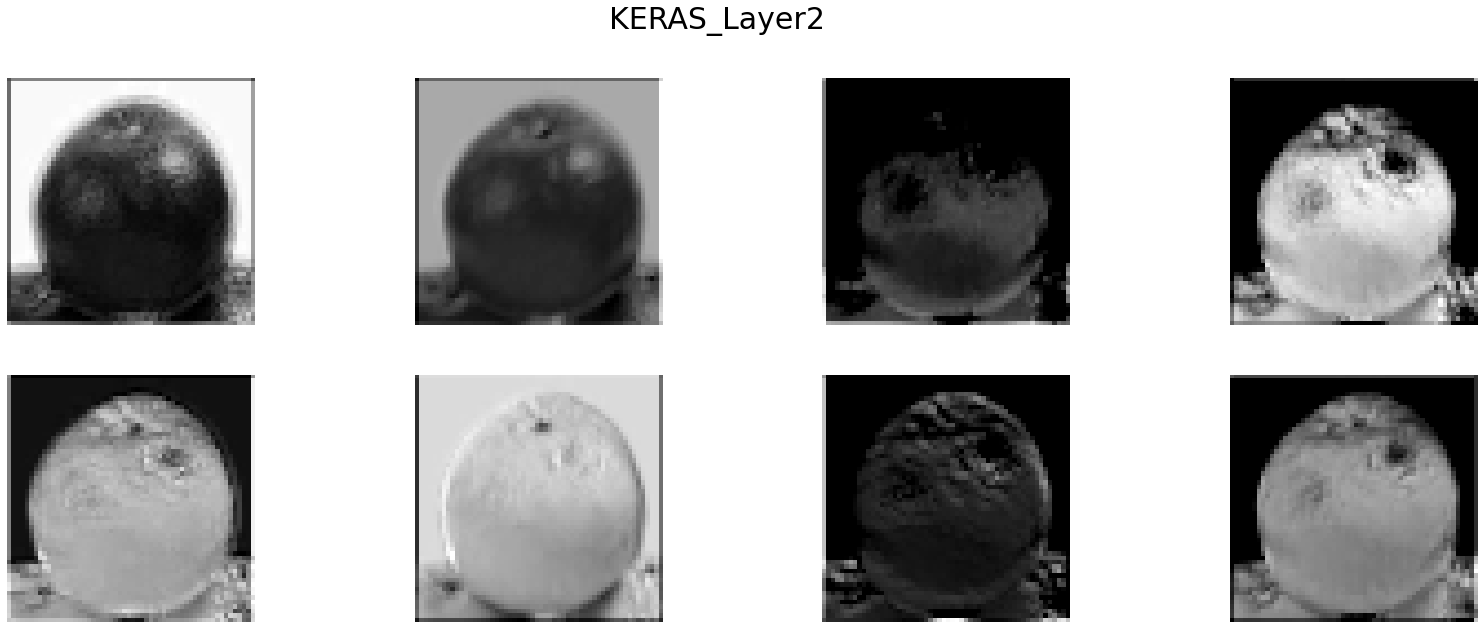

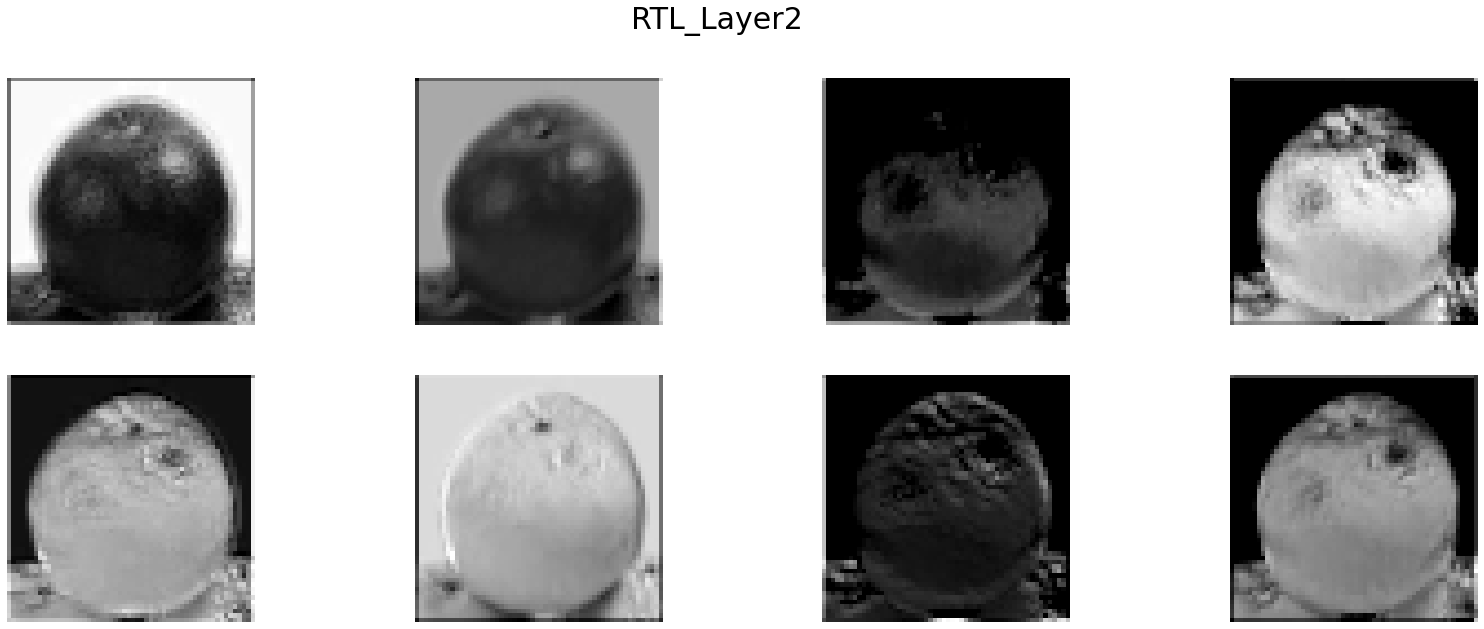

In [15]:
import struct
from PIL import Image

from tensorflow import keras
import cv2

def bintofloat(value):
    temp = int(value, 2)
    return struct.unpack('f', struct.pack('I', temp))[0]

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5')

pic = 0
type = 'Orange'
y = 15


if type == 'Orange':
  path = '/content/drive/MyDrive/ColabNotebooks/data/test/orange/orange_' + str(1000+pic) + '.jpg'
else:
  path = '/content/drive/MyDrive/ColabNotebooks/data/test/apple/apple_' + str(10000+pic) + '.jpg'

x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x /255.0
x = np.asarray(x) 
x = np.expand_dims(x, axis=0)

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]
conv3 = base_model.layers[3]
conv4 = base_model.layers[4]
maxpool2 = base_model.layers[5]
conv5 = base_model.layers[6]
conv6 = base_model.layers[7]
conv7 = base_model.layers[8]
maxpool3 = base_model.layers[9]
conv8 = base_model.layers[10]
conv9 = base_model.layers[11]
conv10 = base_model.layers[12]
maxpool4 = base_model.layers[13]
conv11 = base_model.layers[14]
conv12 = base_model.layers[15]
conv13 = base_model.layers[16]
maxpool5 = base_model.layers[17]
glopool = base_model.layers[18]
fc1 = base_model.layers[19]
fc2 = base_model.layers[20]

lay1 = conv1(x)
lay2 = conv2(lay1)
pool1 = maxpool1(lay2)
lay3 = conv3(pool1)
lay4 = conv4(lay3)
pool2 = maxpool2(lay4)
lay5 = conv5(pool2)
lay6 = conv6(lay5)
lay7 = conv7(lay6)
pool3 = maxpool3(lay7)
lay8 = conv8(pool3)
lay9 = conv9(lay8)
lay10 = conv10(lay9)
pool4 = maxpool4(lay10)
lay11 = conv11(pool4)
lay12 = conv12(lay11)
lay13 = conv13(lay12)
pool5 = maxpool5(lay13)
glob = glopool(pool5)
full1 = fc1(glob)
full2 = fc2(full1)

x = x.squeeze()

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

pool1 = pool1.numpy()
pool1 = pool1.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

lay4 = lay4.numpy()
lay4 = lay4.squeeze()

pool2 = pool2.numpy()
pool2 = pool2.squeeze()

lay5 = lay5.numpy()
lay5 = lay5.squeeze()

lay6 = lay6.numpy()
lay6 = lay6.squeeze()

lay7 = lay7.numpy()
lay7 = lay7.squeeze()

pool3 = pool3.numpy()
pool3 = pool3.squeeze()

lay8 = lay8.numpy()
lay8 = lay8.squeeze()

lay9 = lay9.numpy()
lay9 = lay9.squeeze()

lay10 = lay10.numpy()
lay10 = lay10.squeeze()

pool4 = pool4.numpy()
pool4 = pool4.squeeze()

lay11 = lay11.numpy()
lay11 = lay11.squeeze()

lay12 = lay12.numpy()
lay12 = lay12.squeeze()

lay13 = lay13.numpy()
lay13 = lay13.squeeze()

pool5 = pool5.numpy()
pool5 = pool5.squeeze()

glob = glob.numpy()
glob = glob.squeeze()

full1 = full1.numpy()
full1 = full1.squeeze()

full2 = full2.numpy()
full2 = full2.squeeze()


#----------------
for y in range(2,16):

  img = [0,112,56,56,28,28,28,14,14,14,7,7,7,1,1,1]
  lay = [0,8,8,16,16,32,32,32,32,32,32,32,32,32,16,2]

  layer = lay[y]
  img_size = img[y]
  size = (img_size, img_size)
  accu = 0
  z = layer-1

  # if y == 1:
  #   feature_map_show(lay1, "KERAS_Layer"+str(y))
  # elif y == 2:
  #   feature_map_show(pool1, "KERAS_Layer"+str(y))
  # elif y == 3:
  #   feature_map_show(lay3, "KERAS_Layer"+str(y))
  # elif y == 4:
  #   feature_map_show(pool2, "KERAS_Layer"+str(y))
  # elif y == 5:
  #   feature_map_show(lay5, "KERAS_Layer"+str(y))
  # elif y == 6:
  #   feature_map_show(lay6, "KERAS_Layer"+str(y))
  # elif y == 7:
  #   feature_map_show(pool3, "KERAS_Layer"+str(y))
  # elif y == 8:
  #   feature_map_show(lay8, "KERAS_Layer"+str(y))
  # elif y == 9:
  #   feature_map_show(lay9, "KERAS_Layer"+str(y))
  # elif y == 10:
  #   feature_map_show(pool4, "KERAS_Layer"+str(y))
  # elif y == 11:
  #   feature_map_show(lay11, "KERAS_Layer"+str(y))
  # elif y == 12:
  #   feature_map_show(lay12, "KERAS_Layer"+str(y))

  if y >= 1 and y <= 14:
    f = open('/content/drive/MyDrive/ColabNotebooks/data/RTL_' + type + str(pic) + '/input_layer'+ str(y+1) +'.txt', 'r')
  elif y == 15:
    f = open('/content/drive/MyDrive/ColabNotebooks/data/RTL_' + type + str(pic) + '/outCNN.txt', 'r')

  t = f.readline()
  t = f.readline()
  t = f.readline()
  for i in range(size[0]):
    for j in range(size[1]):
      for k in range(0, layer):   
          t = f.readline(32)
          x = float(bintofloat(t))
          if y == 1:
            accu += (x - lay1[i][j][z-k])*(x - lay1[i][j][z-k])
            lay1[i][j][z-k] = x
          elif y == 2:
            accu += (x - pool1[i][j][z-k])*(x - pool1[i][j][z-k])
            pool1[i][j][z-k] = x
          elif y == 3:
            accu += (x - lay3[i][j][z-k])*(x - lay3[i][j][z-k])
            lay3[i][j][z-k] = x
          elif y == 4:
            accu += (x - pool2[i][j][z-k])*(x - pool2[i][j][z-k])
            pool2[i][j][z-k] = x
          elif y == 5:
            accu += (x - lay5[i][j][z-k])*(x - lay5[i][j][z-k])
            lay5[i][j][z-k] = x
          elif y == 6:
            accu += (x - lay6[i][j][z-k])*(x - lay6[i][j][z-k])
            lay6[i][j][z-k] = x
          elif y == 7:
            accu += (x - pool3[i][j][z-k])*(x - pool3[i][j][z-k])
            pool3[i][j][z-k] = x
          elif y == 8:
            accu += (x - lay8[i][j][z-k])*(x - lay8[i][j][z-k])
            lay8[i][j][z-k] = x
          elif y == 9:
            accu += (x - lay9[i][j][z-k])*(x - lay9[i][j][z-k])
            lay9[i][j][z-k] = x
          elif y == 10:
            accu += (x - pool4[i][j][z-k])*(x - pool4[i][j][z-k])
            pool4[i][j][z-k] = x
          elif y == 11:
            accu += (x - lay11[i][j][z-k])*(x - lay11[i][j][z-k])
            lay11[i][j][z-k] = x
          elif y == 12:
            accu += (x - lay12[i][j][z-k])*(x - lay12[i][j][z-k])
            lay12[i][j][z-k] = x
          elif y == 13:
            accu += (x - glob[layer-1-k])*(x - glob[layer-1-k])
            print(glob[layer-1-k], "\t\t", x)
          elif y == 14:
            accu += (x - full1[layer-1-k])*(x - full1[layer-1-k])
            print(full1[layer-1-k], "\t\t", x)
          elif y == 15:
            accu += (x - full2[layer-1-k])*(x - full2[layer-1-k])
            print(full2[layer-1-k], "\t\t", x)
      t = f.readline()
  f.close()

  print("Mean square error:",accu/(img_size*img_size*layer))

# if y == 1:
#   feature_map_show(lay1, "RTL_Layer"+str(y))
# elif y == 2:
#   feature_map_show(pool1, "RTL_Layer"+str(y))
# elif y == 3:
#   feature_map_show(lay3, "RTL_Layer"+str(y))
# elif y == 4:
#   feature_map_show(pool2, "RTL_Layer"+str(y))
# elif y == 5:
#   feature_map_show(lay5, "RTL_Layer"+str(y))
# elif y == 6:
#   feature_map_show(lay6, "RTL_Layer"+str(y))
# elif y == 7:
#   feature_map_show(pool3, "RTL_Layer"+str(y))
# elif y == 8:
#   feature_map_show(lay8, "RTL_Layer"+str(y))
# elif y == 9:
#   feature_map_show(lay9, "RTL_Layer"+str(y))
# elif y == 10:
#   feature_map_show(pool4, "RTL_Layer"+str(y))
# elif y == 11:
#   feature_map_show(lay11, "RTL_Layer"+str(y))
# elif y == 12:
#   feature_map_show(lay12, "RTL_Layer"+str(y))

Print 1 layer with PIL

0


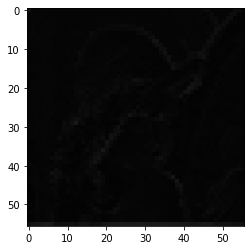

In [ ]:
import struct
from PIL import Image

def bintofloat(value):
    temp = int(value, 2)
    return struct.unpack('f', struct.pack('I', temp))[0]

accu2 = 0

layer = 8

img_size = 56
size = (img_size, img_size)

for k in range(0, 1):
  print(k)
  accu = 0
  f = open('/content/drive/MyDrive/ColabNotebooks/data/Lenna_convert' + str(k) + '.txt', 'r')
  new_img = Image.new('RGB', size)
  pixels_new = new_img.load()
  t = f.readline()
  t = f.readline()
  t = f.readline()
  for i in range(new_img.size[0]):
    for j in range(new_img.size[1]):
        t = f.readline()
        x = float(bintofloat(t))
        pixels_new[j,i] = int(x*255), int(x*255), int(x*255)
        # accu += (x - y[i][j][k]/255.0)*(x - y[i][j][k]/255.0)
        
  f.close()
  # print("pic ", k,":",accu/(112*112))
  # accu2 += accu
  plt.imshow(new_img)
  plt.show()
  new_img.show()

# print("total :", accu2/(112*112*8))

Python code testing

In [ ]:
import math
import struct
from PIL import Image
img_size = 112
size = (img_size, img_size)

from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/test/apple/apple_9.jpg'
x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]

lay1 = conv1(x[np.newaxis,:,:,:])
lay2 = conv2(lay1)
lay3 = maxpool1(lay2)

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

# feature_map_show(lay2, "KERAS_Layer2")
kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]
kernel2 = base_model.layers[1].get_weights()[0]
bias2   = base_model.layers[1].get_weights()[1]


kernel = 3
conv2d = 8
layer = 8
size = 112

for i in range (0, 1):
  for u in range (0, size):
    for v in range (0, size):
      t1 = 0
      for j in range (0, conv2d):
        t0 = 0
        for k in range (-1, kernel-1):
          for l in range (-1, kernel-1):
            if ((u+k >= 0) and (v+l >=0) and (u+k < size) and (v+l < size)):           
              t0 += lay1[u+k][v+l][j]*kernel2[k+1][l+1][j][i]
        t1 += t0
      t1 += bias2[i]
      if u==0 and v==0:
        print(t1*225)
      if u==0 and v==1:
        print(t1)
      if u==1 and v==0:
        print(t1)
      if u==1 and v==1:
        print(t1)

26.22790237655863
0.0006467036437243223
0.07122570735373301
-0.11881923495820956


Get kernel layer

In [ ]:
base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model3.h5') 

kernel1 = base_model.layers[19].get_weights()[0]

print(kernel1.shape)

(32, 16)


gelayer2

In [ ]:
import math
import struct
from PIL import Image
img_size = 112
size = (img_size, img_size)

from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/Lenna.png'
x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]

lay1 = conv1(x[np.newaxis,:,:,:])
lay2 = conv2(lay1)
lay3 = maxpool1(lay2)

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

# feature_map_show(lay2, "KERAS_Layer2")
kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]
kernel2 = base_model.layers[1].get_weights()[0]
bias2   = base_model.layers[1].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))


f = open('/content/drive/MyDrive/ColabNotebooks/data/Lenna_conv2.txt', 'w')

for i in range(0, 10):
  x = ''
  for j in range(0, 8):
    x += binary(lay1[0][i][j])
  f.write(x+'\n')       
f.close()
